In [228]:
bucket = 'ids706'
prefix = 'sagemaker/DEMO-linear-time-series-forecast'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

---
## Data

In [326]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('ids706') 
key = 'btc.csv'

price = pd.read_csv('s3://{}/{}'.format(bucket.name, key))

In [327]:
price['Date'] =  pd.to_datetime(price['Date'], format='%b-%d-%Y')
price.sort_values(by = 'Date', inplace = True)
price = price[price['Date'] >= '2017-01-01'].drop('Date', axis = 1).reset_index(drop = True)
price['Price'] = price['Price'].astype('float32')
price.head()

,Price
0,998.0
1,1022.0
2,1044.0
3,1154.0
4,1011.0


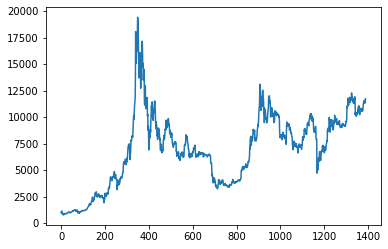

In [328]:
plt.plot(price['Price'])
plt.show()

In [329]:
price['Price_lag1'] = price['Price'].shift(1)
price['Price_lag2'] = price['Price'].shift(2)
price['Price_lag3'] = price['Price'].shift(3)
price['Price_lag4'] = price['Price'].shift(4)
price['trend'] = np.arange(len(price))
price['log_trend'] = np.log1p(np.arange(len(price)))
price['sq_trend'] = np.arange(len(price)) ** 2
weeks = pd.get_dummies(np.array(list(range(100)) * 15)[:len(price)], prefix='week')
price = pd.concat([price, weeks], axis=1)

- Clear out the first four rows where we don't have lagged information.
- Split the target off from the explanatory features.
- Split the data into training, validation, and test groups so that we can tune our model and then evaluate its accuracy on data it hasn't seen yet.  Since this is time-series data, we'll use the first 60% for training, the second 20% for validation, and the final 20% for final test evaluation.

In [227]:
price = price.iloc[4:, ]
split_train = int(len(price) * 0.6)
split_test = int(len(price) * 0.8)

train_y = price['Price'][:split_train]
train_X = price.drop('Price', axis=1).iloc[:split_train, ].to_numpy()
validation_y = price['Price'][split_train:split_test]
validation_X = price.drop('Price', axis=1).iloc[split_train:split_test, ].to_numpy()
test_y = price['Price'][split_test:]
test_X = price.drop('Price', axis=1).iloc[split_test:, ].to_numpy()

In [229]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

In [230]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://ids706/sagemaker/DEMO-linear-time-series-forecast/train/linear_train.data


In [231]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validation_X).astype('float32'), np.array(validation_y).astype('float32'))
buf.seek(0)

0

In [232]:
key = 'linear_validation.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://ids706/sagemaker/DEMO-linear-time-series-forecast/validation/linear_validation.data


---
## Train

In [233]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [234]:
sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=107,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='absolute_loss')

linear.fit({'train': s3_train_data, 'validation': s3_validation_data})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-28 03:11:47 Starting - Starting the training job...
2020-10-28 03:11:49 Starting - Launching requested ML instances......
2020-10-28 03:12:55 Starting - Preparing the instances for training......
2020-10-28 03:14:18 Downloading - Downloading input data...
2020-10-28 03:14:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2020 03:14:50 INFO 140540212991808] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

---
## Host

Create a model and deploy that to a hosted endpoint.

In [235]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

### Forecast

There are multiple ways to generate forecasts.
- One-step-ahead forecasts:  When predicting for multiple data points, one-step-ahead forecasts update the history with the correct known value.  These are common, easy to produce, and can give us some intuition of whether out model is performing as expected.  However, they can also present an unnecessarily optimistic evaluation of the forecast.  In most real-life cases, we want to predict out well into the future, because the actions we may take based on that forecast are not immediate.  In these cases, we want know what the time-periods in between will bring, so generating a forecast based on the knowledge that we do, can be misleading.
- Multi-step-ahead (or horizon) forecasts: In this case, when forecasting out of sample, each forecast builds off of the forecasted periods that precede it.  So, errors early on in the test data can compound to create large deviations for observations late in the test data.  Although this is more realistic, it can be difficult to create the forecasts, particularly as model complexity increases.

In [331]:
price['Price_lag30'] = price['Price'].shift(30)
price['Price_lag60'] = price['Price'].shift(60)

In [332]:
price['Price_naive_forecast'] = pd.Series(np.array(price['Price_lag30']) ** 2 / np.array(price['Price_lag60']))
naive = price[split_test:]['Price_naive_forecast'].to_numpy()

And investigating it's accuracy.

Naive MdAPE = 0.21611413


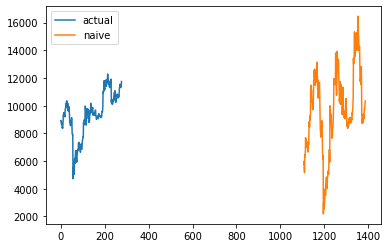

In [342]:
print('Naive MdAPE =', np.median(np.abs((np.array(test_y) - np.array(naive[4:])) / np.array(test_y))))
plt.plot(np.array(test_y), label='actual')
plt.plot(naive, label='naive')
plt.legend()
plt.show()

In [343]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

In [344]:
result = linear_predictor.predict(test_X)
one_step = np.array([r['score'] for r in result['predictions']])

One-step-ahead MdAPE =  0.026714436582751303


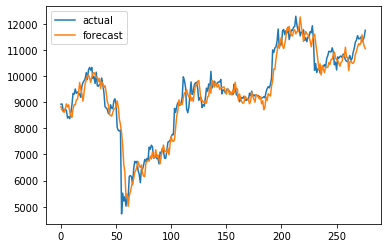

In [346]:
print('One-step-ahead MdAPE = ', np.median(np.abs(np.array(test_y) - one_step) / np.array(test_y)))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()

As we can see our MdAPE is substantially better than the naive, and we actually swing from a forecasts that's too volatile to one that under-represents the noise in our data.  However, the overall shape of the statistical forecast does appear to better represent the actual data.

Next, let's generate multi-step-ahead forecast.  To do this, we'll need to loop over invoking the endpoint one row at a time and make sure the lags in our model are updated appropriately.

In [347]:
multi_step = []
lags = test_X[0, 0:4]
for row in test_X:
    row[0:4] = lags
    result = linear_predictor.predict(row)
    prediction = result['predictions'][0]['score']
    multi_step.append(prediction)
    lags[1:4] = lags[0:3]
    lags[0] = prediction

multi_step = np.array(multi_step)

And now calculate the accuracy of these predictions.

Multi-step-ahead MdAPE = 0.10536022723129648


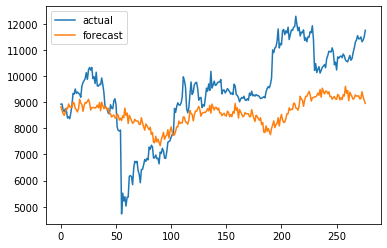

In [349]:
print('Multi-step-ahead MdAPE =', np.median(np.abs(np.array(test_y) - multi_step) / np.array(test_y)))
plt.plot(np.array(test_y), label='actual')
plt.plot(multi_step, label='forecast')
plt.legend()
plt.show()

As we can see our multi-step ahead error performs worse than our one-step ahead forecast, but nevertheless remains substantially stronger than the naive benchmark forecast.  This 1.5 percentage point difference may not seem particularly meaningful, but at the large scale of many topline forecasts can mean millions of dollars in excess supply or lost sales.

### Clean-up

In [ ]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)